<a href="https://colab.research.google.com/github/SabahiJ/DataScienceFinalProject/blob/main/Data_Science_Final_Project_Financial_Sentiment_Tool.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install transformers

In [2]:
 !pip install newsapi-python

In [3]:
pip install huggingface_hub[hf_xet]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 MB 15.1 MB/s eta 0:00:00


In [4]:
# Phase 1: News Data Collection & Ingestion - Extract sentiment-relevant financial news headlines for Nvidia using NewsAPI

# Step 1: Import required libraries
import os
import time
import pandas as pd
from datetime import datetime, timedelta
from newsapi import NewsApiClient

# Step 2: Configure API and prepare output directory
API_KEY = "6fc24465eeb54281b7efa2114bc22223"  # Replace with your API key
newsapi = NewsApiClient(api_key=API_KEY)
os.makedirs("data", exist_ok=True)

# Step 3: Define query terms and sentiment keywords
query = "Nvidia OR NVDA"
sentiment_keywords = [
    "bullish", "bearish", "uptrend", "downtrend", "rally", "plunge", "spike", "drop",
    "soar", "slump", "decline", "jump", "rebound", "surge", "fall", "gain", "beat estimates",
    "miss estimates", "guidance", "forecast", "warning", "record high", "record low",
    "growth", "slowdown", "volatile", "volatility", "recession", "earnings", "strong results",
    "disappoint", "underperform", "outperform", "loss", "profit", "buy", "sell", "upgrade", "downgrade"
]

# Step 4: Define a filter to keep only headlines containing sentiment keywords
def is_sentiment_relevant(headline):
    headline = str(headline).lower()
    return any(keyword in headline for keyword in sentiment_keywords)

# Step 5: Initialize output storage
filtered_articles = []

# Step 6: Define 30-day scraping window sliced into 6-day intervals
end_date = datetime.today()
start_date = end_date - timedelta(days=30)
interval_days = 6

# Step 7: Iterate over each date chunk and fetch news
while start_date < end_date:
    slice_from = start_date.strftime('%Y-%m-%d')
    slice_to = (start_date + timedelta(days=interval_days)).strftime('%Y-%m-%d')

    try:
        print(f"Fetching headlines from {slice_from} to {slice_to}...")
        response = newsapi.get_everything(
            q=query,
            language="en",
            from_param=slice_from,
            to=slice_to,
            sort_by="publishedAt",
            page_size=100,
            page=1
        )

        # Step 8: Filter and collect relevant headlines
        for article in response.get("articles", []):
            headline = article["title"]
            if is_sentiment_relevant(headline):
                filtered_articles.append([
                    article["publishedAt"][:10],
                    "Nvidia",
                    article["source"]["name"],
                    headline,
                    article["url"]
                ])
        time.sleep(1)  # Respect rate limits

    except Exception as e:
        print(f"Error fetching from {slice_from} to {slice_to}: {e}")

    # Step 9: Move to next interval
    start_date += timedelta(days=interval_days)

# Step 10: Convert to DataFrame and export as CSV
df_filtered = pd.DataFrame(filtered_articles, columns=["Date", "Stock", "Source", "Headline", "URL"])
df_filtered.to_csv("data/nvidia_news_raw.csv", index=False)

# Step 11: Confirm export
print(f"{len(df_filtered)} sentiment-relevant Nvidia headlines saved to 'data/nvidia_news_raw.csv'")


Fetching headlines from 2025-04-12 to 2025-04-18...
Fetching headlines from 2025-04-18 to 2025-04-24...
Fetching headlines from 2025-04-24 to 2025-04-30...
Fetching headlines from 2025-04-30 to 2025-05-06...
Fetching headlines from 2025-05-06 to 2025-05-12...
105 sentiment-relevant Nvidia headlines saved to 'data/nvidia_news_raw.csv'


In [5]:
#Phase 2: Sentiment Classification with FinBERT + Data Cleaning
# Step 1: Import required libraries
import os
import pandas as pd
import re
from transformers import pipeline

# Step 2: Ensure the output directory exists
os.makedirs("data", exist_ok=True)

# Step 3: Load raw Nvidia news headlines from Phase 1
input_path = "data/nvidia_news_raw.csv"
df = pd.read_csv(input_path)

# Step 4: Initial Cleaning - Drop empty and duplicate headlines
df.dropna(subset=['Headline'], inplace=True)
df.drop_duplicates(subset='Headline', inplace=True)

# Step 5: Define text preprocessing function (based on data engineering principles)
def clean_text(text):
    text = str(text).lower()  # Convert to lowercase
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)  # Remove URLs
    text = re.sub(r'\@w+|\#','', text)  # Remove @mentions or hashtags
    text = re.sub(r'[^A-Za-z0-9\s]', '', text)  # Remove special characters
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text

# Step 6: Apply text cleaning to the headlines
df['Clean_Headline'] = df['Headline'].apply(clean_text)

# Step 7: Load FinBERT sentiment pipeline
finbert = pipeline("sentiment-analysis", model="ProsusAI/finbert")

# Step 8: Define sentiment analysis function
def analyze_sentiment(text):
    result = finbert(text)[0]  # returns dict: {'label': 'positive', 'score': 0.99}
    return result['label'], result['score']

# Step 9: Apply FinBERT to the cleaned headlines
df[['FinBERT_Label', 'FinBERT_Score']] = df['Clean_Headline'].apply(lambda x: pd.Series(analyze_sentiment(x)))

# Step 10: Map FinBERT output to financial sentiment classes
label_map = {
    "positive": "bullish",
    "negative": "bearish",
    "neutral": "neutral"
}
df['Sentiment_Class'] = df['FinBERT_Label'].str.lower().map(label_map)

# Step 11: Export sentiment-labeled dataset
output_path = "data/nvidia_news_sentiment_labeled.csv"
df.to_csv(output_path, index=False)

# Step 12: Confirm export
print(f"{len(df)} sentiment-labeled and preprocessed Nvidia headlines saved to '{output_path}'")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Device set to use cpu


98 sentiment-labeled and preprocessed Nvidia headlines saved to 'data/nvidia_news_sentiment_labeled.csv'


In [11]:
# Phase 3: Merge & Match Sentiment with Market Movement
# Step 1: Import libraries
import pandas as pd

# Step 2: Load price and sentiment data
price_df = pd.read_csv("/Download Data - STOCK_US_XNAS_NVDA.csv")
sentiment_df = pd.read_csv("/content/data/nvidia_news_sentiment_labeled.csv")

# Step 3: Clean and format the price data
price_df.rename(columns={'Date': 'Date', 'Open': 'Open', 'Close': 'Close'}, inplace=True)
price_df['Date'] = pd.to_datetime(price_df['Date']).dt.strftime('%Y-%m-%d')

# Step 4: Format sentiment dates to match
sentiment_df['Date'] = pd.to_datetime(sentiment_df['Date']).dt.strftime('%Y-%m-%d')

# Step 5: Merge the two datasets on 'Date'
merged_df = pd.merge(sentiment_df, price_df[['Date', 'Open', 'Close']], on='Date', how='inner')

# Step 6: Determine price direction (Up = bullish, Down = bearish)
merged_df['Price_Direction'] = merged_df.apply(
    lambda row: 'bullish' if row['Close'] > row['Open'] else 'bearish',
    axis=1
)

# Step 7: Compare predicted sentiment vs price movement
merged_df['Sentiment_Correct'] = merged_df['Sentiment_Class'] == merged_df['Price_Direction']

# Step 8: Keep only relevant columns
final_df = merged_df[[
    'Date',
    'Headline',
    'Sentiment_Class',
    'FinBERT_Score',
    'Open',
    'Close',
    'Price_Direction',
    'Sentiment_Correct'
]]

# Step 9: Save cleaned output
final_df.to_csv("/content/data/nvidia_sentiment_vs_market.csv", index=False)

# Step 10: Print summary
accuracy = final_df['Sentiment_Correct'].mean()
print(f"{len(final_df)} rows merged. Sentiment aligned with price movement on {accuracy:.2%} of days.")



70 rows merged. Sentiment aligned with price movement on 42.86% of days.


In [19]:
# Phase 4 - Part A: Model Evaluation
# Step 1: Import necessary libraries
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Step 2: Load labeled evaluation dataset
df = pd.read_csv("/nvidia_news_labeled_.csv")

# Step 3: Clean and standardize labels
df['Manual_Label'] = df['Manual_Label'].str.strip().str.lower()
df['FinBERT_Label'] = df['FinBERT_Label'].str.strip().str.lower()

# Step 4: Define ground truth and prediction
y_true = df['Manual_Label']
y_pred = df['FinBERT_Label']

# Step 5: Compute evaluation metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_true, y_pred)
report = classification_report(y_true, y_pred)

# Step 6: Output results
print("Model Evaluation Results (FinBERT vs Manual Labels)")
print("---------------------------------------------------")
print(f"Accuracy Score:  {accuracy:.4f}")
print(f"Precision Score: {precision:.4f}")
print(f"Recall Score:    {recall:.4f}")
print(f"F1 Score:        {f1:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(report)


Model Evaluation Results (FinBERT vs Manual Labels)
---------------------------------------------------
Accuracy Score:  0.7667
Precision Score: 0.7850
Recall Score:    0.7667
F1 Score:        0.7676

Confusion Matrix:
[[6 3 0]
 [0 8 1]
 [2 1 9]]

Classification Report:
              precision    recall  f1-score   support

    negative       0.75      0.67      0.71         9
     neutral       0.67      0.89      0.76         9
    positive       0.90      0.75      0.82        12

    accuracy                           0.77        30
   macro avg       0.77      0.77      0.76        30
weighted avg       0.79      0.77      0.77        30



In [13]:
# Phase 4 - Part B: Evaluate FinBERT sentiment vs market movement
# Step 1: Load sentiment-market merged file
df_market = pd.read_csv("data/nvidia_sentiment_vs_market.csv")

# Step 2: Compute signal success rate
total_rows = len(df_market)
correct = df_market['Sentiment_Correct'].sum()
accuracy = correct / total_rows

# Step 3: Print result
print("\nSentiment Signal Evaluation (FinBERT Sentiment vs Price Direction)")
print("------------------------------------------------------------------")
print(f"Signal Accuracy: {accuracy:.2%} ({correct} out of {total_rows} correct)")



Sentiment Signal Evaluation (FinBERT Sentiment vs Price Direction)
------------------------------------------------------------------
Signal Accuracy: 42.86% (30 out of 70 correct)


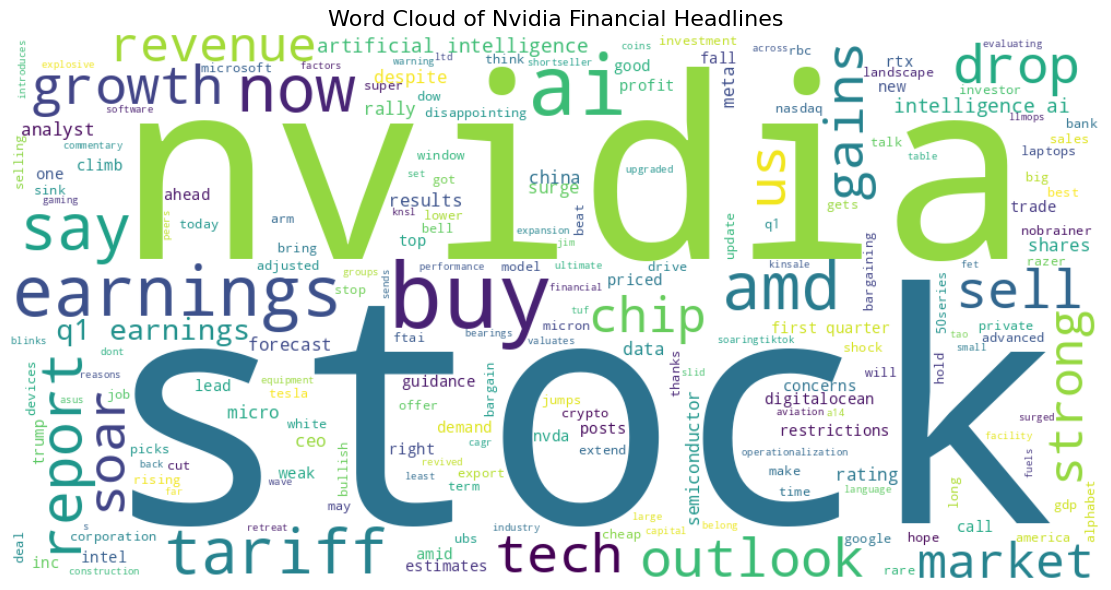

In [20]:
#Phase 5 –  Data Visualisation - EDA Word Cloud
# Step 1: Import libraries
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Step 2: Load your sentiment-labeled dataset
df = pd.read_csv("data/nvidia_news_sentiment_labeled.csv")

# Step 3: Join all cleaned headlines into a single string
text = ' '.join(df['Clean_Headline'].dropna().astype(str))

# Step 4: Generate the word cloud
wordcloud = WordCloud(width=1000, height=500, background_color='white').generate(text)

# Step 5: Plot it
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Nvidia Financial Headlines", fontsize=16)
plt.tight_layout()
plt.show()


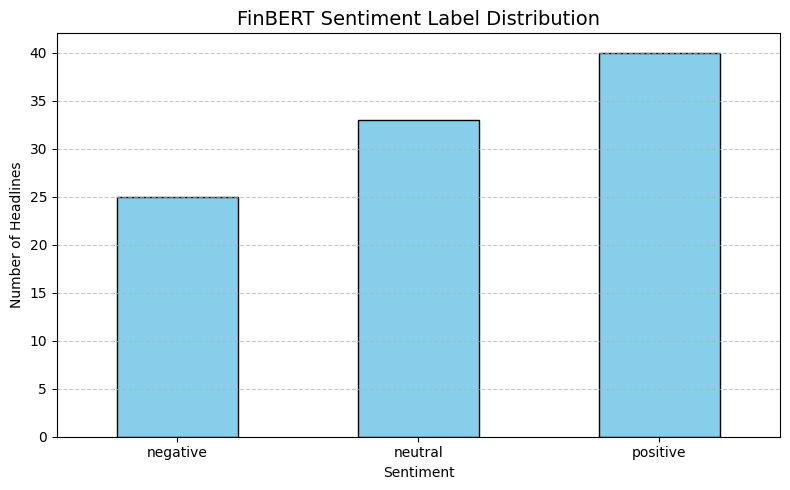

In [21]:
# Distribution of Sentiment Labels (FinBERT Output)
#Step 1: Import libraries
import pandas as pd
import matplotlib.pyplot as plt

# Step 2: Load the labeled dataset
df = pd.read_csv("data/nvidia_news_sentiment_labeled.csv")

# Step 3: Count occurrences of each sentiment class
sentiment_counts = df['FinBERT_Label'].value_counts().sort_index()

# Step 4: Plot bar chart
plt.figure(figsize=(8, 5))
sentiment_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("FinBERT Sentiment Label Distribution", fontsize=14)
plt.xlabel("Sentiment")
plt.ylabel("Number of Headlines")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

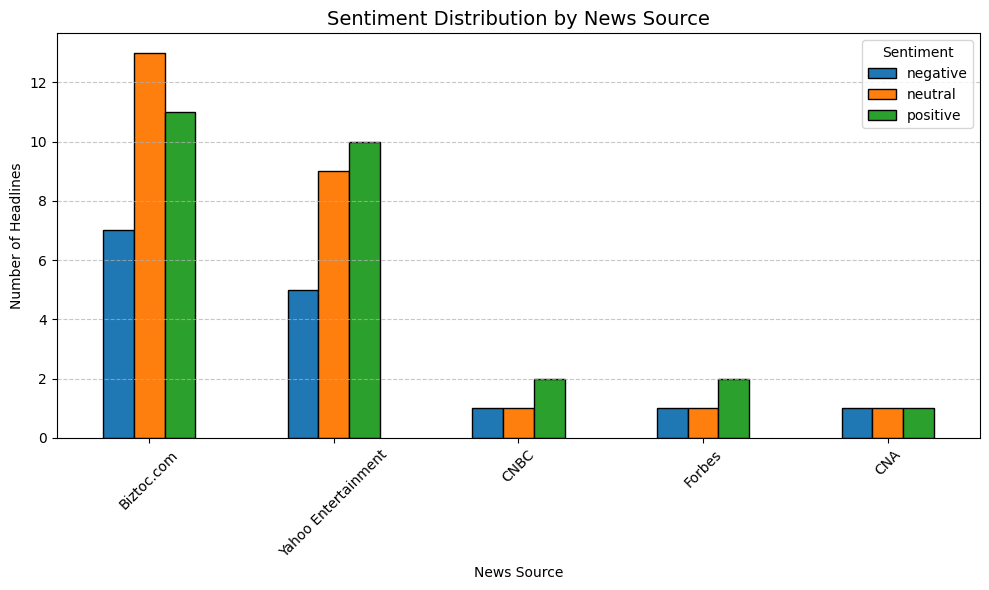

In [22]:
# Sentiment by News Source (Grouped Bar Chart)
#Step 1: Import libraries
import pandas as pd
import matplotlib.pyplot as plt

# Step 2: Load sentiment-labeled data
df = pd.read_csv("data/nvidia_news_sentiment_labeled.csv")

# Step 3: Count sentiment occurrences per news source
source_sentiment = df.groupby(['Source', 'FinBERT_Label']).size().unstack().fillna(0)

# Optional: Limit to top 5 most frequent sources for clarity
top_sources = df['Source'].value_counts().nlargest(5).index
source_sentiment = source_sentiment.loc[top_sources]

# Step 4: Plot grouped bar chart
source_sentiment.plot(kind='bar', figsize=(10, 6), edgecolor='black')

# Step 5: Aesthetic adjustments
plt.title("Sentiment Distribution by News Source", fontsize=14)
plt.xlabel("News Source")
plt.ylabel("Number of Headlines")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title="Sentiment")
plt.tight_layout()
plt.show()


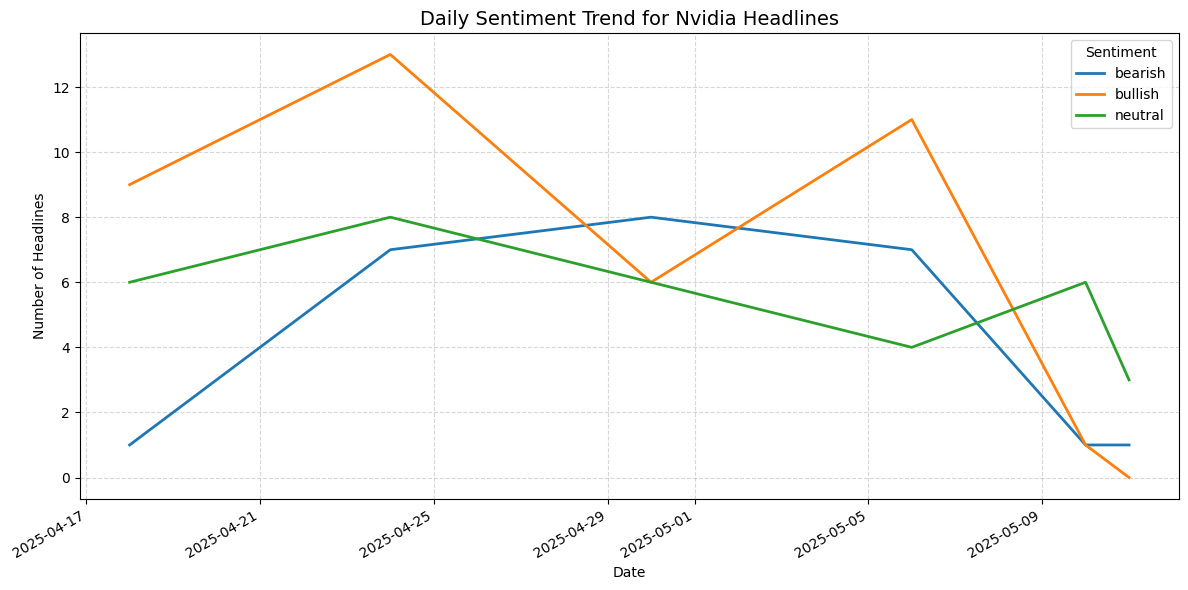

In [23]:
# Sentiment Trend Over Time (Line Plot)
# Step 1: Import libraries
import pandas as pd
import matplotlib.pyplot as plt

# Step 2: Load data
df = pd.read_csv("data/nvidia_news_sentiment_labeled.csv")

# Step 3: Preprocess for time series
df['Date'] = pd.to_datetime(df['Date'])
df_grouped = df.groupby(['Date', 'Sentiment_Class']).size().unstack(fill_value=0)

# Step 4: Plot the sentiment trend
df_grouped.plot(figsize=(12, 6), linewidth=2)

# Step 5: Aesthetics
plt.title("Daily Sentiment Trend for Nvidia Headlines", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Number of Headlines")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title="Sentiment")
plt.tight_layout()
plt.show()


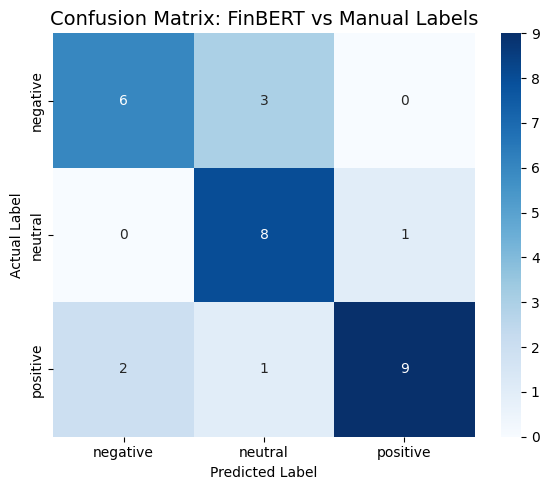

In [25]:
# Confusion Matrix (FinBERT vs Manual Labels)
#Step 1: Import libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Step 2: Load evaluation data
df = pd.read_csv("/nvidia_news_labeled_.csv")
df['Manual_Label'] = df['Manual_Label'].str.strip().str.lower()
df['FinBERT_Label'] = df['FinBERT_Label'].str.strip().str.lower()

# Step 3: Generate confusion matrix
labels = ['negative', 'neutral', 'positive']
cm = confusion_matrix(df['Manual_Label'], df['FinBERT_Label'], labels=labels)

# Step 4: Plot confusion matrix heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix: FinBERT vs Manual Labels", fontsize=14)
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.tight_layout()
plt.show()


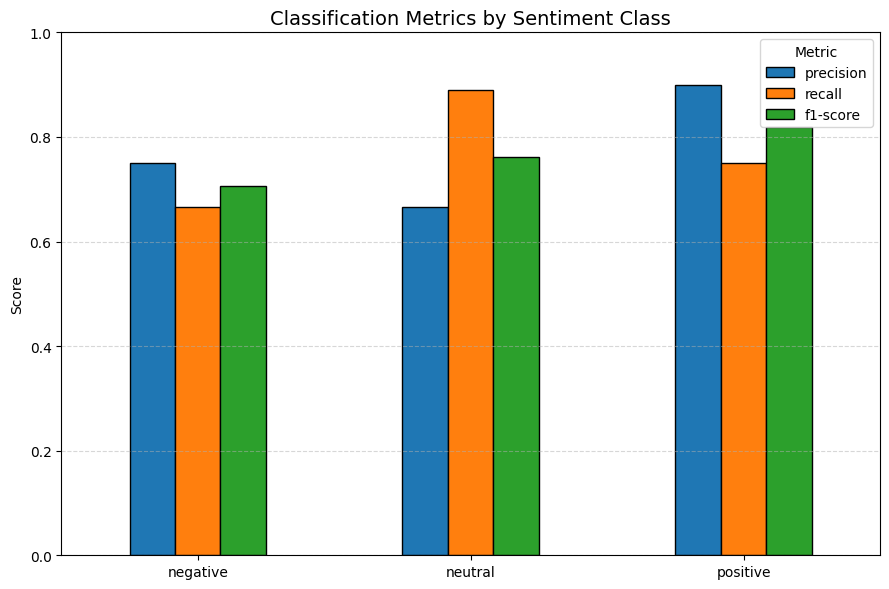

In [27]:
# Precision, Recall, and F1-Score (Grouped Bar)
# Step 1: Import required libraries
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# Step 2: Load labeled evaluation dataset
df = pd.read_csv("/nvidia_news_labeled_.csv")
df['Manual_Label'] = df['Manual_Label'].str.strip().str.lower()
df['FinBERT_Label'] = df['FinBERT_Label'].str.strip().str.lower()

# Step 3: Generate classification report as dictionary
report = classification_report(df['Manual_Label'], df['FinBERT_Label'], output_dict=True, zero_division=0)

# Step 4: Create DataFrame for plotting
df_report = pd.DataFrame(report).T.loc[['negative', 'neutral', 'positive'], ['precision', 'recall', 'f1-score']]

# Step 5: Plot grouped bar chart
df_report.plot(kind='bar', figsize=(9, 6), edgecolor='black')
plt.title("Classification Metrics by Sentiment Class", fontsize=14)
plt.ylabel("Score")
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.legend(title="Metric")
plt.tight_layout()
plt.show()


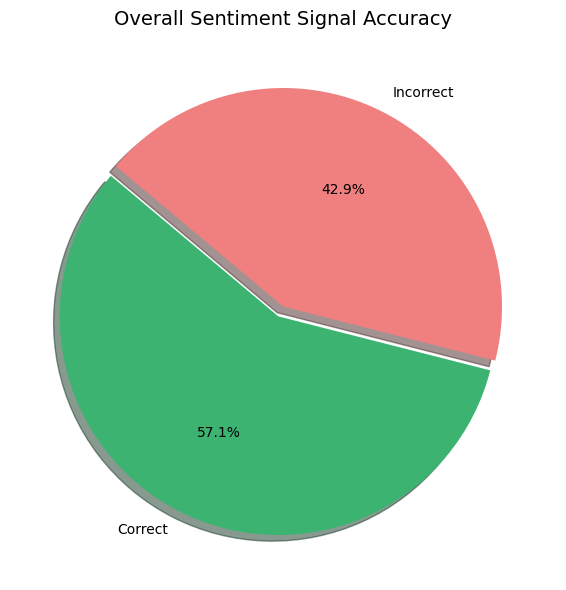

In [28]:
# Overall Signal Accuracy (Pie Chart)
#Step 1: Load the sentiment vs market match data
df = pd.read_csv("data/nvidia_sentiment_vs_market.csv")

# Step 2: Count correct vs incorrect predictions
counts = df['Sentiment_Correct'].value_counts()

# Step 3: Plot pie chart
plt.figure(figsize=(6, 6))
plt.pie(counts, labels=['Correct', 'Incorrect'], autopct='%1.1f%%', startangle=140,
        colors=['mediumseagreen', 'lightcoral'], explode=(0.05, 0), shadow=True)
plt.title("Overall Sentiment Signal Accuracy", fontsize=14)
plt.tight_layout()
plt.show()


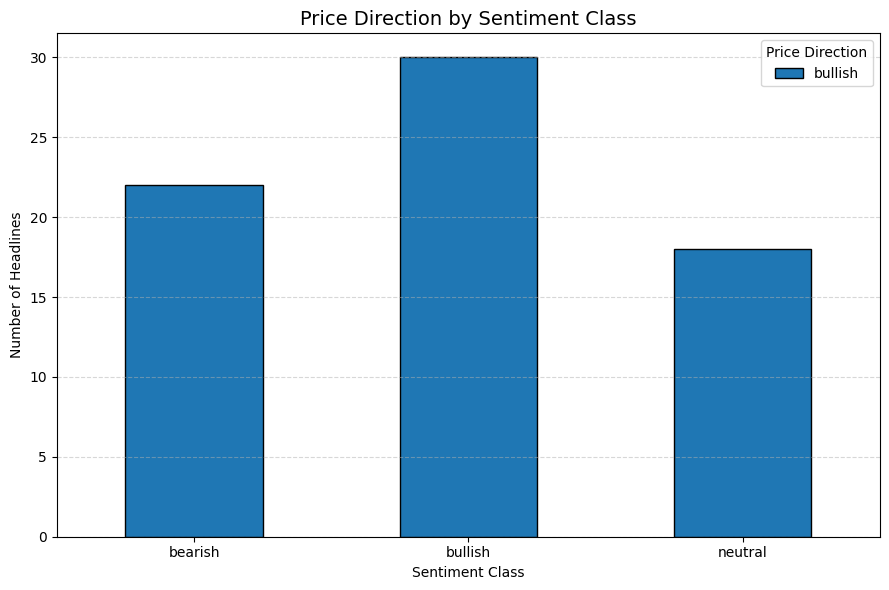

In [29]:
#Sentiment vs Price Direction (Stacked Bar)
# Step 1: Cross-tabulate Sentiment Class vs Price Direction
stacked_data = df.groupby(['Sentiment_Class', 'Price_Direction']).size().unstack(fill_value=0)

# Step 2: Plot stacked bar chart
stacked_data.plot(kind='bar', stacked=True, figsize=(9, 6), edgecolor='black')

# Step 3: Aesthetics
plt.title("Price Direction by Sentiment Class", fontsize=14)
plt.xlabel("Sentiment Class")
plt.ylabel("Number of Headlines")
plt.xticks(rotation=0)
plt.legend(title="Price Direction")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


<ipython-input-33-db0b6b50ce58>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Sentiment_Class', y='Price_Change_%', palette='pastel')


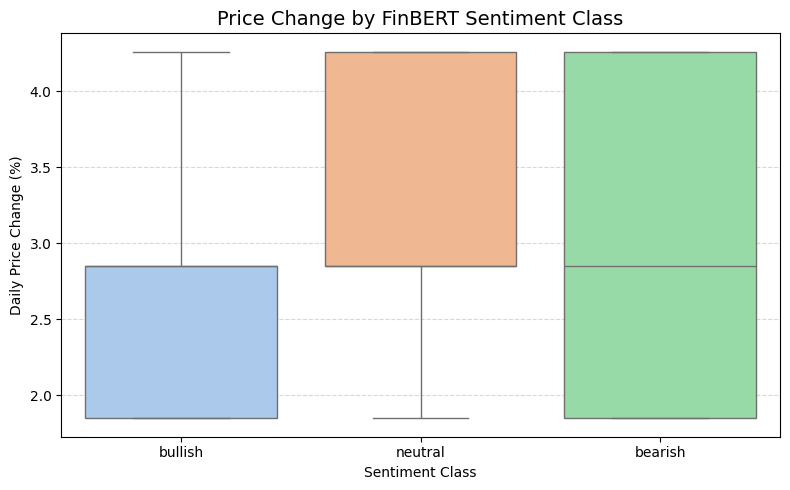

In [33]:
# Price Change vs Sentiment (Boxplot)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Load merged dataset (includes sentiment + price data)
df = pd.read_csv("data/nvidia_sentiment_vs_market.csv")

# Step 2: Compute daily price change
df['Price_Change_%'] = ((df['Close'] - df['Open']) / df['Open']) * 100

# Step 3: Plot boxplot grouped by sentiment
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x='Sentiment_Class', y='Price_Change_%', palette='pastel')
plt.title("Price Change by FinBERT Sentiment Class", fontsize=14)
plt.xlabel("Sentiment Class")
plt.ylabel("Daily Price Change (%)")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


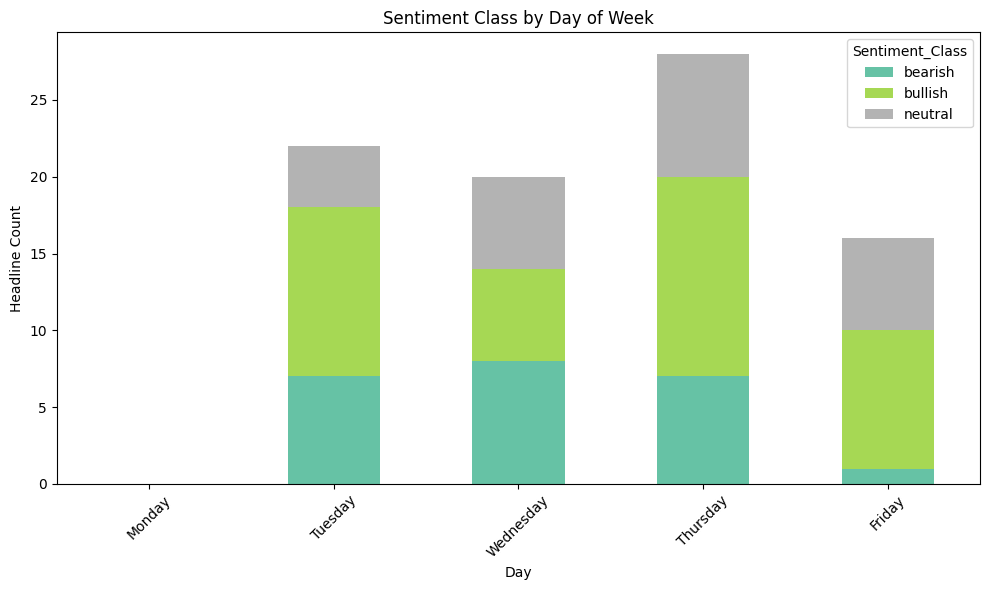

In [34]:
#Sentiment by Day of Week
df = pd.read_csv("data/nvidia_news_sentiment_labeled.csv")
df['Date'] = pd.to_datetime(df['Date'])
df['Weekday'] = df['Date'].dt.day_name()

weekday_sentiment = df.groupby(['Weekday', 'Sentiment_Class']).size().unstack().reindex(
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'])

weekday_sentiment.plot(kind='bar', stacked=True, figsize=(10,6), colormap='Set2')
plt.title("Sentiment Class by Day of Week")
plt.xlabel("Day")
plt.ylabel("Headline Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


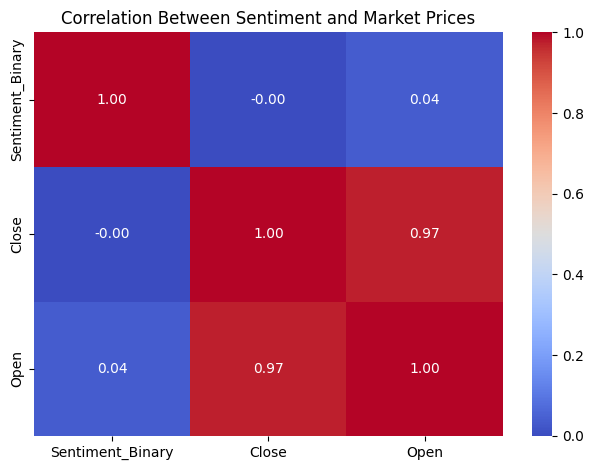

In [35]:
#Heatmap — Sentiment vs Volume Correlation
df = pd.read_csv("data/nvidia_sentiment_vs_market.csv")
df['Sentiment_Binary'] = df['Sentiment_Class'].map({'bullish': 1, 'bearish': -1, 'neutral': 0})
df[['Open', 'Close']] = df[['Open', 'Close']].astype(float)

# Create correlation matrix
cor_matrix = df[['Sentiment_Binary', 'Close', 'Open']].corr()

sns.heatmap(cor_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Between Sentiment and Market Prices")
plt.tight_layout()
plt.show()


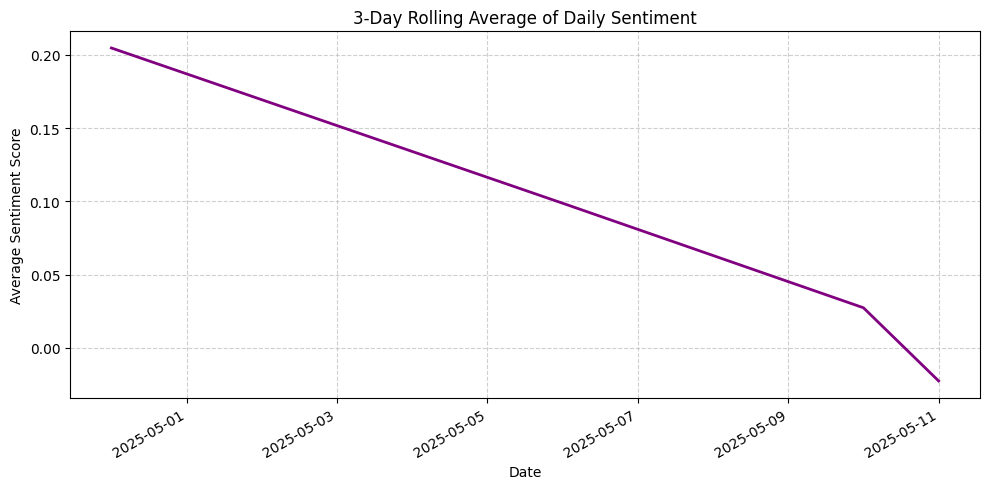

In [36]:
# Rolling Sentiment Trend (SMA)
df = pd.read_csv("data/nvidia_news_sentiment_labeled.csv")
df['Date'] = pd.to_datetime(df['Date'])
sentiment_numeric = df['Sentiment_Class'].map({'bullish': 1, 'neutral': 0, 'bearish': -1})
df['Sentiment_Numeric'] = sentiment_numeric

# Daily average sentiment
daily_avg = df.groupby('Date')['Sentiment_Numeric'].mean().rolling(3).mean()

plt.figure(figsize=(10, 5))
daily_avg.plot(color='purple', linewidth=2)
plt.title("3-Day Rolling Average of Daily Sentiment")
plt.ylabel("Average Sentiment Score")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

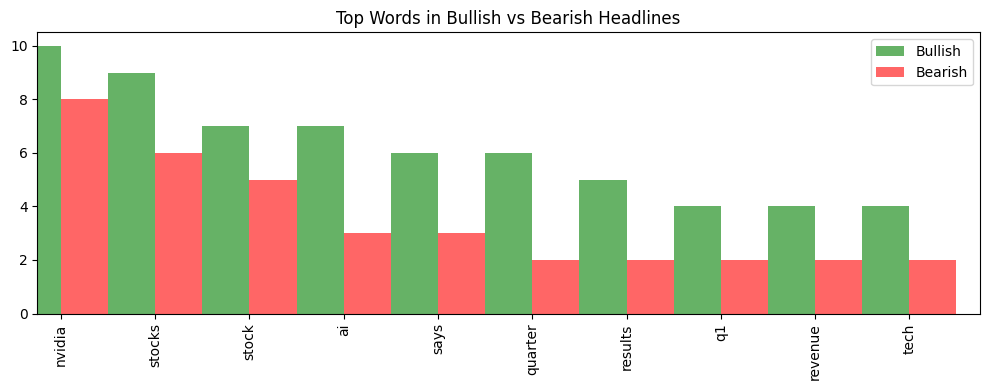

In [37]:
from sklearn.feature_extraction.text import CountVectorizer

df = pd.read_csv("data/nvidia_news_sentiment_labeled.csv")

# Only keep bullish/bearish
bull = df[df['Sentiment_Class'] == 'bullish']['Clean_Headline']
bear = df[df['Sentiment_Class'] == 'bearish']['Clean_Headline']

vectorizer = CountVectorizer(stop_words='english')
bull_matrix = vectorizer.fit_transform(bull)
bear_matrix = vectorizer.transform(bear)

bull_counts = pd.Series(bull_matrix.sum(axis=0).A1, index=vectorizer.get_feature_names_out()).sort_values(ascending=False).head(10)
bear_counts = pd.Series(bear_matrix.sum(axis=0).A1, index=vectorizer.get_feature_names_out()).sort_values(ascending=False).head(10)

# Plot
plt.figure(figsize=(10, 4))
bull_counts.plot(kind='bar', color='green', alpha=0.6, label='Bullish', position=1)
bear_counts.plot(kind='bar', color='red', alpha=0.6, label='Bearish', position=0)
plt.title("Top Words in Bullish vs Bearish Headlines")
plt.legend()
plt.tight_layout()
plt.show()


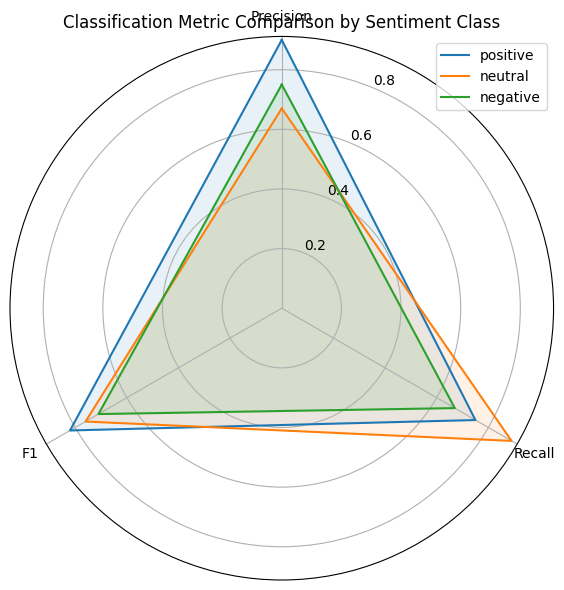

In [40]:
#Radar Chart – Sentiment Class Comparison of Key Metrics
import numpy as np

# Dummy example: Replace with actual values from report if needed
metrics = ['Precision', 'Recall', 'F1']
classes = ['positive', 'neutral', 'negative']
values = [
    [0.90, 0.75, 0.82],  # Positive
    [0.67, 0.89, 0.76],  # Neutral
    [0.75, 0.67, 0.71]   # Negative
]

# Radar setup
angles = np.linspace(0, 2 * np.pi, len(metrics), endpoint=False).tolist()
angles += angles[:1]

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
for i, row in enumerate(values):
    row += row[:1]
    ax.plot(angles, row, label=classes[i])
    ax.fill(angles, row, alpha=0.1)

ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.set_thetagrids(np.degrees(angles[:-1]), metrics)
plt.title("Classification Metric Comparison by Sentiment Class")
plt.legend()
plt.tight_layout()
plt.show()


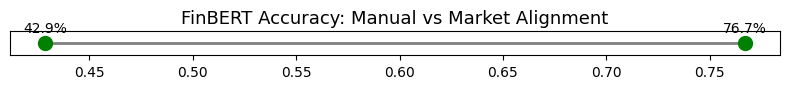

In [42]:
#Dumbbell Plot – Accuracy vs Market vs Manual
import pandas as pd
import matplotlib.pyplot as plt

# Dummy values: Replace with real results
labels = ['Model Accuracy (Manual)', 'Market Match Accuracy']
scores = [0.767, 0.4286]

plt.figure(figsize=(8, 1))
plt.hlines(y=0, xmin=min(scores), xmax=max(scores), color='gray', linewidth=2)
plt.plot(scores, [0, 0], 'o', color='green', markersize=10)
plt.text(scores[0], 0.05, f"{scores[0]*100:.1f}%", ha='center')
plt.text(scores[1], 0.05, f"{scores[1]*100:.1f}%", ha='center')
plt.title("FinBERT Accuracy: Manual vs Market Alignment", fontsize=13)
plt.yticks([])
plt.tight_layout()
plt.show()


In [43]:
import pandas as pd
from IPython.display import display

summary = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'Market Match Accuracy'],
    'Score': [0.767, 0.785, 0.767, 0.768, 0.4286]
})

summary['Score'] = summary['Score'].apply(lambda x: f"{x*100:.2f}%")
display(summary)


,Metric,Score
0,Accuracy,76.70%
1,Precision,78.50%
2,Recall,76.70%
3,F1 Score,76.80%
4,Market Match Accuracy,42.86%
